In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys
from google.colab.patches import cv2_imshow
import random
sys.setrecursionlimit(10**7)

In [3]:
"""
Takes a 2d image array, and uses canny's algorithm to output
an array of 0's where 1's correspond to edges of features in the image
"""
def get_edge_array(img, edge_dense = False):
    sigma = .01
    med = np.median(img)
    v = np.median(img)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    # img = cv2.GaussianBlur(img, (3,3),0)
    # cv2_imshow(img)

    edges = cv2.Canny(img,lower,upper)


    # edges = sobel_edge_detector(img)
    cv2_imshow(edges)
    if edge_dense:
      blurred = cv2.GaussianBlur(edges,(5,5),0)
      cv2_imshow(blurred)
      return blurred
    return edges

"""
Given a set of coords, an image array showing edges, and an x,y coordinate to start on,
check if the current pixel is an edge, if so stop, otherwise check its neighbors, and add
if not an edge.
"""
def get_region(coords,im,x,y):
    if (x < im.shape[0] and x >= 0 and y < im.shape[1] and y >= 0):
        pixel = im[x][y]
    else:
        return
    if pixel > 0:
      coords.add((x,y))
      return
    else:
      coords.add((x,y))
      if (x+1,y) not in coords:
        get_region(coords, im,x+1,y)
      if (x-1,y) not in coords:
        get_region(coords,im,x-1,y)
      if (x, y+1) not in coords:
        get_region(coords,im,x,y+1)
      if (x, y-1) not in coords:
        get_region(coords,im,x,y-1)
      return 
"""
Gets all coordinates for 2D image array
"""
def get_all_coords(arr):
  X, Y = np.mgrid[0:arr.shape[0], 0:arr.shape[1]]
  a = np.vstack((X.ravel(), Y.ravel()))
  t = [tuple(i) for i in a.T]
  return set(t)

"""
Randomly chooses points on the image to run get_region until all regions are filled in
besides the edges.
"""
def get_all_regions(edges,num_iters=1500):
    points_seen = set()
    i = 0
    all_coords = get_all_coords(edges)
    regions = []
    while (i < num_iters):
      remaining = all_coords - points_seen
      if len(remaining) == 0:
        break
      e = random.choice(list(remaining))
      x = e[0]
      y = e[1]
      region = set()
      get_region(region, edges, x,y)
      regions.append(region)
      points_seen.update(region)
      i += 1
    

    return regions, remaining
  

"""
Takes an img array and colors a coord
according to a len 3 list RGB
"""
def color_in(img, coord, BGR):
  img[coord[0]][coord[1]] = BGR

In [9]:
def get_colors_of_regions(regions, scribbled_img, original_image):
  color_map = {}
  
  for i in range(len(regions)):
    region = regions[i]
    if len(region) > 0:
      color_map[i] = get_color_of_region(region, scribbled_img, original_image)
  return color_map
def get_color_of_region(region, scribbled_img, original_img):
  maxdiff = 0
  max_color = None
  for pixel in region:
    color = list(scribbled_img[pixel[0]][pixel[1]])
    r = int(color[0])
    g = int(color[1])
    b = int(color[2])
    a1 = abs(r-g)
    a2 = abs(r-b)
    a3 = abs(b-g)
    if max([a1,a2,a3]) > maxdiff:
      maxdiff = max([a1, a2, a3])
      max_color = color
  if max_color == None:
    for pixel in region:
      return scribbled_img[pixel[0]][pixel[1]]
  return max_color

  """
Given a black and white image with color scribbles (scribbled), and 
the same BW image without the scribbles (original), color in
"""
def colorize(original, scribbled, edge_dense = False, fill_remaining = False):
    edges = get_edge_array(original, edge_dense = edge_dense)
    r, remaining = get_all_regions(edges)
    color_map = get_colors_of_regions(r, scribbled, original)
    backtobgr = cv2.cvtColor(original,cv2.COLOR_GRAY2BGR)
    for key in color_map:
      region = r[key]
      color = color_map[key]
      color_scheme = generate_monochromatic_scheme(color, original, region)
      for pixel in region:
        x = pixel[0]
        y = pixel[1]
        brightness = original[x][y]/255
        color_in(backtobgr, pixel, scale_color(color_scheme, brightness))
    if fill_remaining:
      colorized_edge_undense = colorize(original,scribbled, edge_dense = False)
      for pixel in remaining:
        backtobgr[pixel[0]][pixel[1]] = colorized_edge_undense[pixel[0]][pixel[1]]
    return backtobgr

"""
Given a monochromatic scheme, output a color based on the brightness input
Monochromatic scheme
"""
def scale_color(color_scheme, brightness):
    index = int(brightness*(len(color_scheme) - 1))
    return color_scheme[index]

def generate_monochromatic_scheme(color, original, region, num_windows = 5000, sigma = 1):
    b = color[0]
    g = color[1]
    r = color[2]
    scheme = []

    values = sorted(list(np.random.normal(1,sigma,num_windows)))
    for scale in values:
      v1,v2,v3 = min(255,scale*b),min(255,scale*g),min(255,scale*r)
      c = [max([0,v1]),max([0,v2]),max([0,v3])]
      scheme.append(c)
    return scheme

In [5]:
def print_color(color):
  img = []
  for i in range(50):
    row = []
    for j in range(50):
      row.append(color)
    img.append(row)
  cv2_imshow(np.array(img))



def view_regions(img, scribble, edge_dense = False):
    edges = get_edge_array(img, edge_dense = edge_dense)
    regions, remaining = get_all_regions(edges)
    for r in regions:
      
      if len(r) >0:
        black_img = []
        for i in range(img.shape[0]):
          row = []
          for j in range(img.shape[1]):
            row.append([0,0,0])
          black_img.append(row)
        black_img = np.array(black_img)
        for pixel in r:
          black_img[pixel[0]][pixel[1]] = [150,150,150]
        cv2_imshow(black_img)
        color = get_color_of_region(r, scribble, img)
        print("COLOR:", color)
        print("INDEX:",regions.index(r))
        print_color(color)
      
          

In [ ]:
def sobel_edge_detector(img):
  
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    grad = np.sqrt(grad_x**2 + grad_y**2)
    grad_norm = (grad * 255 / grad.max()).astype(np.uint8)
    return grad_norm

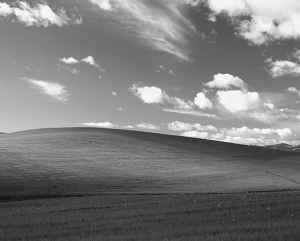

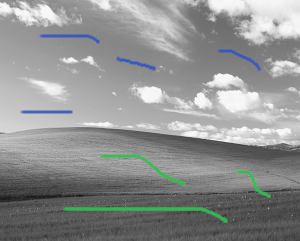

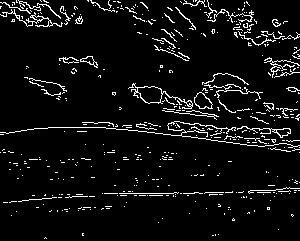

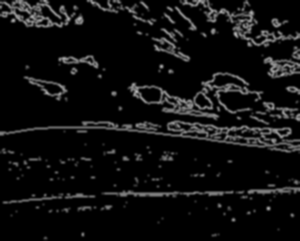

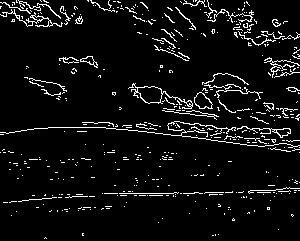

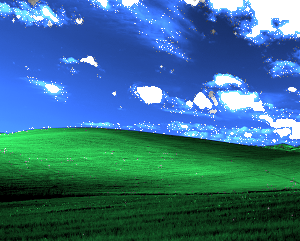

In [10]:

original_filename = "Bliss_(Windows_XP).png"
scribbled_filename = "Bliss_(Windows_XP)_scribble.png"

# original_filename = "egypt_pyramids.jpeg"
# scribbled_filename = "egypt_pyramids_scribble.jpeg"

# original_filename = "trees.png"
# scribbled_filename = "trees_scribble.png"

# original_filename = "dum_dum.jpeg"
# scribbled_filename = "dum_dum_scribble.jpeg"

# original_filename = "flower.png"
# scribbled_filename = "flower_scribble.png"

# original_filename = "spotify.png"
# scribbled_filename = "spotify_scribble.png"

# original_filename = "harambe.png"
# scribbled_filename = "harambe_scribble.png"

scribbled = cv2.imread(scribbled_filename)
original = cv2.imread(original_filename, 0)
# original_color = cv2.imread(original_filename)



cv2_imshow(original)
cv2_imshow(scribbled)
# view_regions(original, scribbled, edge_dense = False) 
# # cv2_imshow(original_color)
colorized = colorize(original, scribbled, edge_dense = True, fill_remaining = True)
cv2_imshow(colorized)